## Goals: Training the _Final_ Models

This notebook trains the model on the full _baseline_dataset_ for the final prediction on evaluation data.

Here, we train a model designed to generalize across water stations in Brazil and France. However, you are not required to follow this approach and may opt to train separate models for different geographic _regions_.

This baseline model training example utilizes all available features, with hyperparameters chosen for quick execution rather than optimization. For hyperparameter tuning and feature selection explorations, refer to the `02_exploration` folder.

> **Note:** This notebook requires outputs from the `00 Preprocessing` notebooks.

<img src="../images/notebook-3.png" alt="Experiment Diagram" style="width:75%; text-align:center;" />

### 1. Data Import and Setup

This section imports the necessary libraries, sets up environment paths, and includes custom utility functions.


In [121]:
import os
import sys

import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb
import tensorflow as tf
import lightgbm as lgb

from interpret.glassbox import ExplainableBoostingRegressor
from mapie.regression import MapieQuantileRegressor
from quantile_forest import RandomForestQuantileRegressor

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..")))

from src.utils.model import (
    split_dataset,
    compare_models_per_station,
    create_deep_model,
    XGBQuantileRegressor,
    standardize_prediction_intervals,
    standardize_values,
    get_station_stats,
)

from src.utils.helpers import check_columns_exist

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Constants :

- **INPUT_DIR**: Directory for input data (same as in "02 - Feature Engineering").
- **MODEL_DIR**: Directory where trained models are saved.
- **DATASET_DIR**: Directory where the Zenodo dataset is unzipped.

##### Model Parameters

- **SEED**: 42 (for reproducibility)
- **NUMBER_OF_WEEK**: 4 (one model is trained per week)

##### FINAL_MODELS

- **mapie**: Combines LightGBM with MAPIE. **MAPIE** (Model Agnostic Prediction Interval Estimator) computes prediction intervals for any regression model using conformal methods.
- **qrf**: Quantile Random Forest (natively produces prediction intervals)
- **ebm**: Explainable Boosting Machine is used as a exemple that does not natively implement prediction intervals, but that can be customised to do so.


In [146]:
INPUT_DIR = "../../../data/input/"
DATASET_DIR = "../../../dataset/"

DATASET_TRANSFORMS = [
    "rm_gnv_st",
    "pca",
    "snow_index",
    "snow_index_lag",
    # "oh_enc_date",
    "cyc_enc_date",
    "clust_index",
    "clust_index_oh",
    "clust_hydro",
    "clust_hydro_oh",
    # "scl_feat",
    # "scl_feat_wl",  # Scale all except waterflow lag
    # "rm_wl",  # remove custom generated water_flow_lag 3w & 4w ---> Need USE_CUSTOM_PREPROCESS = True
    "slct_ma",  # keep only specific mobile average 2w or/and 3w or/and 4w ---> Need USE_CUSTOM_PREPROCESS = True
    "lag_slope",  # add an indicator that is calculated between water_flow_lag 1w and 2w
    "target_precipitation",
]

PCA_THRESHOLD = 0.98
N_CLUSTER = 5

DATASET_SPEC = "_".join(DATASET_TRANSFORMS)

if "pca" in DATASET_TRANSFORMS:
    DATASET_SPEC += f"_pct_{PCA_THRESHOLD}"

if "clust_index" in DATASET_TRANSFORMS:
    DATASET_SPEC += f"_geocl_{N_CLUSTER}"

if "clust_hydro" in DATASET_TRANSFORMS:
    DATASET_SPEC += f"_hydcl_{N_CLUSTER}"

MODEL_DIR = f"../../../models/{DATASET_SPEC}/"

SEED = 42
NUMBER_OF_WEEK = 4  # Number of weeks to predict one model is trained per week

FINAL_MODELS = [
    "qrf",
    "xgb_qrf",
    "xgb_qrf_simple",
    "ensemble",
]


COLUMNS_TO_DROP = [
    "water_flow_week1",
    "water_flow_week2",
    "water_flow_week3",
    "water_flow_week4",
]

PRECIPITATION_TARGETS = [
    "precipitations_pca_1_w1",
    "precipitations_pca_1_w2",
    "precipitations_pca_1_w3",
    "precipitations_pca_1_w4",
]

ALPHA = 0.1
TIME_VALIDATION = "2000-01-01 00:00:00"

### 2. Data Loading

Load in the baseline datasets, create the directory to save models.


In [167]:
dataset_train = pd.read_csv(f"{INPUT_DIR}dataset_{DATASET_SPEC}.csv")

dataset_train = dataset_train.set_index("ObsDate")

if not os.path.exists(f"{MODEL_DIR}final/"):
    os.makedirs(f"{MODEL_DIR}final/")

### Data Pre-processing

Data pre-processing removal of unnecessary columns, setup of the target


In [168]:
X_train = dataset_train.drop(columns=COLUMNS_TO_DROP)

precipitation_targets_exist = len(
    check_columns_exist(X_train, PRECIPITATION_TARGETS)
) < len(PRECIPITATION_TARGETS)

if precipitation_targets_exist:
    X_train = X_train.drop(columns=PRECIPITATION_TARGETS)

Y_train = {}
for i in range(0, NUMBER_OF_WEEK):
    Y_train[i] = dataset_train[f"water_flow_week{i+1}"]

In [169]:
def get_y_train(df, number_of_weeks=NUMBER_OF_WEEK):
    y_train = {}
    df_copy = df.copy()
    if "water_flow_week1" not in df_copy.columns:
        raise ValueError("water_flow_week1 not in columns")
    for i in range(0, number_of_weeks):
        y_train[i] = df[f"water_flow_week{i+1}"]
        df_copy.drop(columns=[f"water_flow_week{i+1}"], inplace=True)
    return df_copy, y_train

In [170]:
train_split, test_split, eval_split = split_dataset(
    dataset_train, 0.75, TIME_VALIDATION
)

# if precipitation_targets_exist:
#     train_split = train_split.drop(columns=PRECIPITATION_TARGETS)
#     test_split = test_split.drop(columns=PRECIPITATION_TARGETS)
#     eval_split = eval_split.drop(columns=PRECIPITATION_TARGETS)

x_train, y_train = get_y_train(train_split.drop(columns=["station_code"]))
x_test, y_test = get_y_train(test_split.drop(columns=["station_code"]))
x_eval, y_eval = get_y_train(eval_split)

### Precipitation prediction


In [171]:
from xgboost import XGBRegressor

precipitation_predictors = {}

y_train_precipitation = {}
y_val_precipitation = {}
pred_columns = []

categorical_columns = [
    "region_cluster_0",
    "region_cluster_1",
    "region_cluster_2",
    "region_cluster_3",
    "region_cluster_4",
    "hydro_cluster_0",
    "hydro_cluster_1",
    "hydro_cluster_2",
    "hydro_cluster_3",
    "hydro_cluster_4",
]

if "target_precipitation" in DATASET_TRANSFORMS:
    # storing the targets for the precipitation
    if not bool(y_train_precipitation):
        for i in range(NUMBER_OF_WEEK):
            y_train_precipitation[i] = x_train[f"precipitations_pca_1_w{i+1}"]
            y_val_precipitation[i] = x_test[f"precipitations_pca_1_w{i+1}"]

    for i in range(NUMBER_OF_WEEK):
        print(f"Training precipitation predictor for week {i+1}")
        precipitation_predictors[i] = XGBRegressor(
            n_estimators=1000,
            max_depth=7,
            learning_rate=0.1,
            enable_categorical=True,
            early_stopping_rounds=5,
        )

        X_train_precipitation = x_train.drop(
            columns=pred_columns + PRECIPITATION_TARGETS
        )
        X_train_precipitation[categorical_columns] = X_train_precipitation[
            categorical_columns
        ].astype("category")

        precipitation_predictors[i].fit(
            X_train_precipitation,
            y_train_precipitation[i],
            eval_set=[
                (
                    x_test.drop(columns=pred_columns + PRECIPITATION_TARGETS),
                    y_val_precipitation[i],
                )
            ],
        )

        print(
            f"Predictor score : {
                precipitation_predictors[i]
                .score(X_train_precipitation,
                y_train_precipitation[i])}"
        )

        prediction_columns_name = f"precipitation_prediction_week_{i+1}"

        # X_train[prediction_columns_name] = precipitation_predictors[i].predict(
        #     X_train_precipitation
        # )

        x_train[prediction_columns_name] = precipitation_predictors[i].predict(
            x_train.drop(columns=pred_columns + PRECIPITATION_TARGETS)
        )

        x_test[prediction_columns_name] = precipitation_predictors[i].predict(
            x_test.drop(columns=pred_columns + PRECIPITATION_TARGETS)
        )

        x_eval[prediction_columns_name] = precipitation_predictors[i].predict(
            x_eval.drop(columns=["station_code"] + pred_columns + PRECIPITATION_TARGETS)
        )

        pred_columns.append(prediction_columns_name)

        time_str = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        file_path = f"{MODEL_DIR}final/precipitation_predictor_{time_str}_week_{i}.pkl"
        joblib.dump(precipitation_predictors[i], file_path)
        print(f"Saved Precipitation Predictor for week {i} to {file_path}")

Training precipitation predictor for week 1
[0]	validation_0-rmse:0.06900
[1]	validation_0-rmse:0.06900
[2]	validation_0-rmse:0.06900
[3]	validation_0-rmse:0.06900
[4]	validation_0-rmse:0.06900
[5]	validation_0-rmse:0.06900
[6]	validation_0-rmse:0.06900
[7]	validation_0-rmse:0.06900
[8]	validation_0-rmse:0.06899
[9]	validation_0-rmse:0.06899
[10]	validation_0-rmse:0.06899
[11]	validation_0-rmse:0.06899
[12]	validation_0-rmse:0.06899
[13]	validation_0-rmse:0.06899
[14]	validation_0-rmse:0.06899
[15]	validation_0-rmse:0.06899
[16]	validation_0-rmse:0.06899
[17]	validation_0-rmse:0.06899
[18]	validation_0-rmse:0.06899
[19]	validation_0-rmse:0.06899
[20]	validation_0-rmse:0.06899
[21]	validation_0-rmse:0.06899
[22]	validation_0-rmse:0.06899
[23]	validation_0-rmse:0.06899
[24]	validation_0-rmse:0.06899
[25]	validation_0-rmse:0.06899
[26]	validation_0-rmse:0.06899
[27]	validation_0-rmse:0.06899
[28]	validation_0-rmse:0.06899
[29]	validation_0-rmse:0.06899
[30]	validation_0-rmse:0.06899
[31]	

In [ ]:
if precipitation_targets_exist:
    train_split = train_split.drop(columns=PRECIPITATION_TARGETS)
    test_split = test_split.drop(columns=PRECIPITATION_TARGETS)
    eval_split = eval_split.drop(columns=PRECIPITATION_TARGETS)

### 2. Models training


#### b. QRF

- **Training:**  
  Initializes a `RandomForestQuantileRegressor` with the following parameters:

  - 100 estimators
  - Maximum depth of 10
  - Minimum of 10 samples per leaf

  These parameters allow for relatively fast training, though they are not optimized for peak performance.

  The model is then fitted using `X_train` and the corresponding weekly target `y_train[i]`.


In [128]:
X_train_qrf = X_train.drop(columns=["station_code"])

qrf = {}

best_params_qrf = {
    "n_estimators": 130,
    "min_samples_split": 30,
    "min_samples_leaf": 20,
    "max_features": None,
    "max_depth": 30,
    "bootstrap": True,
}

if "qrf" in FINAL_MODELS:
    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")
        # Train RandomForestQuantileRegressor
        qrf[i] = RandomForestQuantileRegressor(**best_params_qrf, random_state=SEED)
        qrf[i].fit(X_train_qrf, Y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/qrf_quantile_{time}_week_{i}.pkl"
        joblib.dump(qrf[i], model_path)

Training week 0
Training week 1
Training week 2
Training week 3


#### g. XGBoost + QRF


In [129]:
from xgboost import XGBRegressor


class XGBQRF_SimpleModel:
    def __init__(self, xgb_params: dict, qrf_params: dict, quantiles: list = []):
        self.xgb_params = xgb_params
        self.qrf_params = qrf_params
        self.quantiles = quantiles
        self.models = {
            "XGB": XGBRegressor(**self.xgb_params, random_state=SEED),
            "QRF": RandomForestQuantileRegressor(**self.qrf_params, random_state=SEED),
        }
        self.predictions = None

    def fit(self, X, y, eval_set: list = [], prev_week_models=[]):
        week = len(prev_week_models)
        if len(prev_week_models) > 0:
            for model in prev_week_models:
                print(model.predictions.shape)
                print(X.shape)
                X = pd.concat(
                    [
                        X.reset_index(drop=True),
                        model.predictions.reset_index(drop=True),
                    ],
                    axis=1,
                )
        print("Fitting XGB models")
        self.models["XGB"].fit(X, y, eval_set=eval_set, verbose=False)
        print("Fitting QRF model")
        self.models["QRF"].fit(X, y)

        self.save_predictions(X, week)

    def save_predictions(self, X, week, predictions=None):
        if predictions is None:
            predictions = self.predict(X)

        predictions = pd.DataFrame(
            {
                f"predicted_water_flow_week{week}_lower": predictions[:, 0],
                f"predicted_water_flow_week{week}_median": predictions[:, 1],
                f"predicted_water_flow_week{week}_upper": predictions[:, 2],
            }
        )

        predictions.set_index(X.index)
        self.predictions = predictions

    def predict(self, X, prev_week_models=[]):
        week = len(prev_week_models)
        if len(prev_week_models) > 0:
            for model in prev_week_models:
                X = pd.concat(
                    [
                        X.reset_index(drop=True),
                        model.predictions.reset_index(drop=True),
                    ],
                    axis=1,
                )
        xgb_predictions = self.models["XGB"].predict(X)

        qrf_predictions = self.models["QRF"].predict(X, quantiles=self.quantiles)

        qrf_median = qrf_predictions[:, 1]

        # Threshold on xgb_predictions
        xgb_predictions[xgb_predictions < 100] = qrf_median[xgb_predictions < 100]

        qrf_lower_gap = (
            qrf_median - qrf_predictions[:, 0]
        ) / qrf_median  # à soustraire
        lower_bound = xgb_predictions * (1 - qrf_lower_gap)

        qrf_upper_gap = (qrf_predictions[:, 2] - qrf_median) / qrf_median  # à ajouter
        upper_bound = xgb_predictions * (1 + qrf_upper_gap)

        predictions = np.stack(
            [lower_bound, xgb_predictions, upper_bound],
            axis=1,
        )

        self.save_predictions(X, week, predictions)

        return predictions

    def predict_separate(self, X):
        predictions = dict()
        predictions["XGB"] = self.models["XGB"].predict(X)
        predictions["QRF"] = self.models["QRF"].predict(X, quantiles=self.quantiles)
        return predictions

In [130]:
class XGBQRFModel:
    def __init__(
        self, xgb_params: dict = {}, qrf_params: dict = {}, quantiles: list = []
    ):
        self.xgb_params = xgb_params
        self.qrf_params = qrf_params
        self.quantiles = quantiles
        self.models = {
            "XGB": {
                q: XGBQuantileRegressor(quantile=q, **self.xgb_params)
                for q in self.quantiles
            },
            "QRF": RandomForestQuantileRegressor(**self.qrf_params),
        }

    def fit(self, X, y, eval_set: list = [], X_qrf=None, y_qrf=None):
        print("Fitting XGB models")
        for q in self.quantiles:
            self.models["XGB"][q].fit(X, y, eval_set=eval_set)
        print("Fitting QRF model")
        if not X_qrf is None and not y_qrf is None:
            X, y = X_qrf, y_qrf
        self.models["QRF"].fit(X, y)

    def predict(self, X):
        xgb_predictions = np.stack(
            [model.predict(X) for model in self.models["XGB"].values()], axis=1
        )

        qrf_predictions = self.models["QRF"].predict(X, quantiles=self.quantiles)
        qrf_lower_dist = qrf_predictions[:, 1] - qrf_predictions[:, 0]
        qrf_upper_dist = qrf_predictions[:, 2] - qrf_predictions[:, 1]

        lower = (xgb_predictions[:, 1] - qrf_lower_dist).clip(min=0)
        upper = xgb_predictions[:, 1] + ((qrf_upper_dist + xgb_predictions[:, 2]) / 2)
        return np.stack(
            [lower, xgb_predictions[:, 1], upper],
            axis=1,
        )

In [131]:
xgb_qrf_quantiles = [ALPHA / 2, 0.5, 1 - ALPHA / 2]

xgb_simple_params = {
    "subsample": 0.6,
    "reg_lambda": 1,
    "reg_alpha": 0.01,
    "n_estimators": 300,
    "min_child_weight": 5,
    "max_depth": 5,
    "learning_rate": 0.05,
    "gamma": 0.1,
    "colsample_bytree": 0.8,
}

xgb_qrf_simple_models = []

if "xgb_qrf_simple" in FINAL_MODELS:
    for i in range(NUMBER_OF_WEEK):
        print(f"Training XGB-QRF for week {i}")
        xgb_qrf_simple = XGBQRF_SimpleModel(
            xgb_params=xgb_simple_params,
            qrf_params=best_params_qrf,
            quantiles=xgb_qrf_quantiles,
        )

        xgb_qrf_simple.fit(
            x_train,
            y_train[i],
            eval_set=[(x_test, y_test[i])],
        )

        xgb_qrf_simple_models.append(xgb_qrf_simple)

        time_str = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        file_path = f"{MODEL_DIR}final/xgb_qrf_simple_{time_str}_week_{i}.pkl"
        joblib.dump(xgb_qrf_simple, file_path)
        print(f"Saved XGB-QRF simple for week {i} to {file_path}")

Training XGB-QRF for week 0
Fitting XGB models
Fitting QRF model
Saved XGB-QRF simple for week 0 to ../../../models/rm_gnv_st_pca_snow_index_snow_index_lag_cyc_enc_date_clust_index_clust_index_oh_clust_hydro_clust_hydro_oh_slct_ma_lag_slope_target_precipitation_pct_0.98_geocl_5_hydcl_5/final/xgb_qrf_simple_2025-04-21_12-39-46_week_0.pkl
Training XGB-QRF for week 1
Fitting XGB models
Fitting QRF model
Saved XGB-QRF simple for week 1 to ../../../models/rm_gnv_st_pca_snow_index_snow_index_lag_cyc_enc_date_clust_index_clust_index_oh_clust_hydro_clust_hydro_oh_slct_ma_lag_slope_target_precipitation_pct_0.98_geocl_5_hydcl_5/final/xgb_qrf_simple_2025-04-21_12-40-18_week_1.pkl
Training XGB-QRF for week 2
Fitting XGB models
Fitting QRF model
Saved XGB-QRF simple for week 2 to ../../../models/rm_gnv_st_pca_snow_index_snow_index_lag_cyc_enc_date_clust_index_clust_index_oh_clust_hydro_clust_hydro_oh_slct_ma_lag_slope_target_precipitation_pct_0.98_geocl_5_hydcl_5/final/xgb_qrf_simple_2025-04-21_12-

In [132]:
xgb_qrf_quantiles = [ALPHA / 2, 0.5, 1 - ALPHA / 2]

xgb_qrf_models = []

xgb_qrf_params = {
    # "subsample": 0.6,
    # "reg_lambda": 1,
    # "reg_alpha": 0.01,
    "n_estimators": 500,
    # "min_child_weight": 5,
    "max_depth": 5,
    "learning_rate": 0.05,
    # "gamma": 0.1,
    # "colsample_bytree": 0.8,
}

if "xgb_qrf" in FINAL_MODELS:
    for i in range(NUMBER_OF_WEEK):
        print(f"Training XGB-QRF for week {i}")
        xgb_qrf = XGBQRFModel(
            xgb_params=xgb_qrf_params,
            qrf_params=best_params_qrf,
            quantiles=xgb_qrf_quantiles,
        )

        xgb_qrf.fit(
            x_train,
            y_train[i],
            eval_set=[
                (
                    x_test,
                    y_test[i],
                )
            ],
        )

        xgb_qrf_models.append(xgb_qrf)

        time_str = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        file_path = f"{MODEL_DIR}final/xgb_qrf_{time_str}_week_{i}.pkl"
        joblib.dump(xgb_qrf, file_path)
        print(f"Saved XGB-QRF for week {i} to {file_path}")

Training XGB-QRF for week 0
Fitting XGB models
Fitting QRF model
Saved XGB-QRF for week 0 to ../../../models/rm_gnv_st_pca_snow_index_snow_index_lag_cyc_enc_date_clust_index_clust_index_oh_clust_hydro_clust_hydro_oh_slct_ma_lag_slope_target_precipitation_pct_0.98_geocl_5_hydcl_5/final/xgb_qrf_2025-04-21_12-41-51_week_0.pkl
Training XGB-QRF for week 1
Fitting XGB models
Fitting QRF model
Saved XGB-QRF for week 1 to ../../../models/rm_gnv_st_pca_snow_index_snow_index_lag_cyc_enc_date_clust_index_clust_index_oh_clust_hydro_clust_hydro_oh_slct_ma_lag_slope_target_precipitation_pct_0.98_geocl_5_hydcl_5/final/xgb_qrf_2025-04-21_12-42-27_week_1.pkl
Training XGB-QRF for week 2
Fitting XGB models
Fitting QRF model
Saved XGB-QRF for week 2 to ../../../models/rm_gnv_st_pca_snow_index_snow_index_lag_cyc_enc_date_clust_index_clust_index_oh_clust_hydro_clust_hydro_oh_slct_ma_lag_slope_target_precipitation_pct_0.98_geocl_5_hydcl_5/final/xgb_qrf_2025-04-21_12-42-58_week_2.pkl
Training XGB-QRF for week

#### h. Ensemble


In [133]:
class Ensemble:
    def __init__(self, xgb_params, qrf_params, quantiles):
        self.xgb_params = xgb_params
        self.qrf_params = qrf_params
        self.models = {
            0: XGBQRFModel(
                xgb_params={
                    "n_estimators": 300,
                    "max_depth": 5,
                    "learning_rate": 0.1,
                },
                qrf_params={
                    "n_estimators": 30,
                    "max_depth": 10,
                },
                quantiles=quantiles,
            ),
            1: XGBQRFModel(
                xgb_params={
                    "n_estimators": 300,
                    "max_depth": 5,
                    "learning_rate": 0.1,
                },
                qrf_params={
                    "n_estimators": 30,
                    "max_depth": 10,
                },
                quantiles=quantiles,
            ),
            2: XGBQRFModel(
                xgb_params=xgb_params,
                qrf_params=self.qrf_params,
                quantiles=quantiles,
            ),
        }

    def fit(self, X, y, eval_set: list = [], X_qrf=None, y_qrf=None):
        for i in self.models.keys():
            print(f"Training model {i}")
            if i == 0:
                # Brazil dedicated
                x_brazil = X[X["north_hemisphere"] == 0]
                y_brazil = y[X["north_hemisphere"] == 0]
                x_brazil_qrf = None
                y_brazil_qrf = None
                if not X_qrf is None and not y_qrf is None:
                    x_brazil_qrf = X_qrf[X_qrf["north_hemisphere"] == 0]
                    y_brazil_qrf = y_qrf[X_qrf["north_hemisphere"] == 0]
                # brazil_eval =
                self.models[i].fit(
                    x_brazil,
                    y_brazil,
                    eval_set=eval_set,
                    X_qrf=x_brazil_qrf,
                    y_qrf=y_brazil_qrf,
                )
            elif i == 1:
                x_north = X[X["north_hemisphere"] == 1]
                y_north = y[X["north_hemisphere"] == 1]
                x_north_qrf = None
                y_north_qrf = None
                if not X_qrf is None and not y_qrf is None:
                    x_north_qrf = X_qrf[X_qrf["north_hemisphere"] == 1]
                    y_north_qrf = y_qrf[X_qrf["north_hemisphere"] == 1]
                self.models[i].fit(
                    x_north,
                    y_north,
                    eval_set=eval_set,
                    X_qrf=x_north_qrf,
                    y_qrf=y_north_qrf,
                )
            else:
                self.models[i].fit(X, y, eval_set=eval_set, X_qrf=X_qrf, y_qrf=y_qrf)

    def predict(self, X):
        predictions = []
        for i in self.models.keys():
            pred = self.models[i].predict(X)
            predictions.append(pred)

        # Stack predictions: shape = (n_samples, n_models, n_quantiles)
        predictions = np.stack(predictions, axis=1)  # (N, 3, Q)

        # Initialize weights: shape = (n_samples, n_models)
        weights = np.ones((X.shape[0], len(self.models)))

        # Dynamic weights based on 'north_hemisphere'
        north = X["north_hemisphere"].values  # shape (n_samples,)

        weights[:, 0] = np.where(north == 0, 0.6, 0.0)  # Brazil model
        weights[:, 1] = np.where(north == 1, 0.6, 0.0)  # North model
        weights[:, 2] = 0.4  # General model

        # Normalize weights
        weights /= weights.sum(axis=1, keepdims=True)  # (N, 3)

        # Multiply weights with predictions
        # predictions: (N, 3, Q) * weights[:, :, None] → (N, 3, Q)
        weighted_predictions = predictions * weights[:, :, None]

        # Sum over models: (N, Q)
        final_prediction = np.sum(weighted_predictions, axis=1)

        return final_prediction

In [134]:
xgb_qrf_quantiles = [ALPHA / 2, 0.5, 1 - ALPHA / 2]

xgb_qrf_params = {
    # "subsample": 0.6,
    # "reg_lambda": 1,
    # "reg_alpha": 0.01,
    "n_estimators": 500,
    # "min_child_weight": 5,
    "max_depth": 5,
    "learning_rate": 0.05,
    # "gamma": 0.1,
    # "colsample_bytree": 0.8,
}

ensemble_models = []

for i in range(NUMBER_OF_WEEK):
    print(f"Training XGB-QRF for week {i}")
    ensemble = Ensemble(
        xgb_params=xgb_qrf_params,
        qrf_params=best_params_qrf,
        quantiles=xgb_qrf_quantiles,
    )

    ensemble.fit(
        x_train,
        y_train[i],
        eval_set=[
            (
                x_test,
                y_test[i],
            )
        ],
    )

    ensemble_models.append(ensemble)

    time_str = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
    file_path = f"{MODEL_DIR}final/ensemble_{time_str}_week_{i}.pkl"
    joblib.dump(ensemble, file_path)
    print(f"Saved Ensemble for week {i} to {file_path}")

Training XGB-QRF for week 0
Training model 0
Fitting XGB models
Fitting QRF model
Training model 1
Fitting XGB models
Fitting QRF model
Training model 2
Fitting XGB models
Fitting QRF model
Saved Ensemble for week 0 to ../../../models/rm_gnv_st_pca_snow_index_snow_index_lag_cyc_enc_date_clust_index_clust_index_oh_clust_hydro_clust_hydro_oh_slct_ma_lag_slope_target_precipitation_pct_0.98_geocl_5_hydcl_5/final/ensemble_2025-04-21_12-44-10_week_0.pkl
Training XGB-QRF for week 1
Training model 0
Fitting XGB models
Fitting QRF model
Training model 1
Fitting XGB models
Fitting QRF model
Training model 2
Fitting XGB models
Fitting QRF model
Saved Ensemble for week 1 to ../../../models/rm_gnv_st_pca_snow_index_snow_index_lag_cyc_enc_date_clust_index_clust_index_oh_clust_hydro_clust_hydro_oh_slct_ma_lag_slope_target_precipitation_pct_0.98_geocl_5_hydcl_5/final/ensemble_2025-04-21_12-44-51_week_1.pkl
Training XGB-QRF for week 2
Training model 0
Fitting XGB models
Fitting QRF model
Training model

### 3. Performance Evaluation on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


Predicting week 0


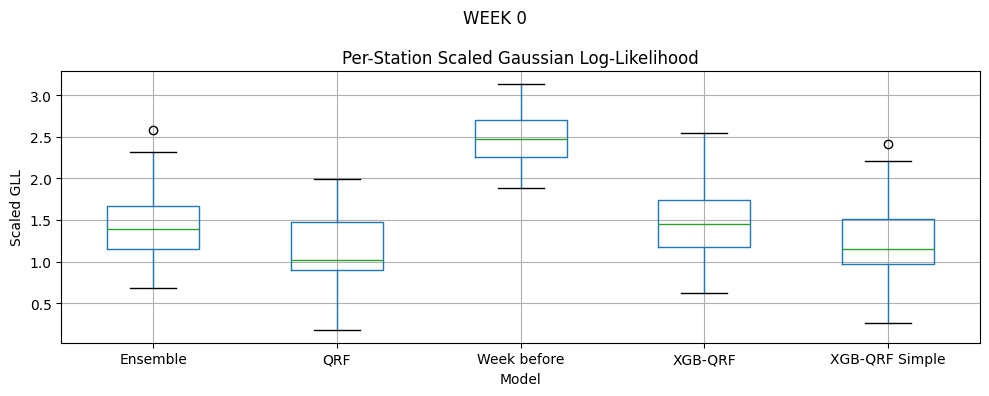

Predicting week 1


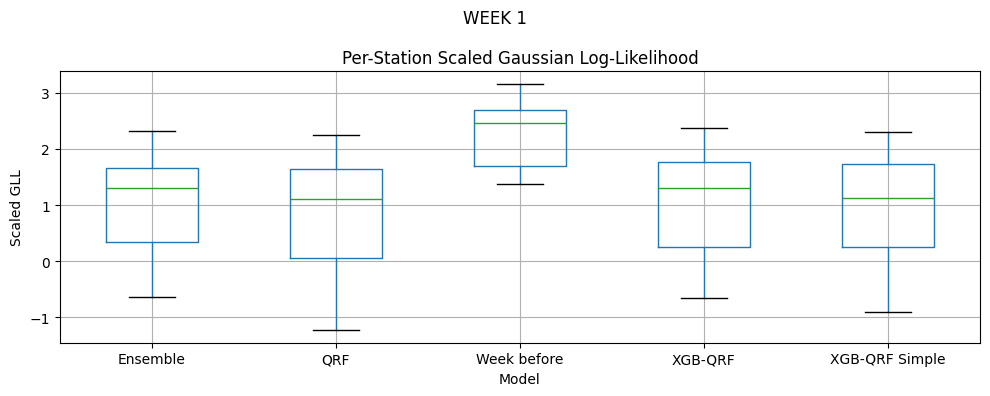

Predicting week 2


/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:196: RuntimeWarning: divide by zero encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:196: RuntimeWarning: divide by zero encountered in divide
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:196: RuntimeWarning: invalid value encountered in add
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:196: RuntimeWarning: divide by zero encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:196: RuntimeWarning: divide by zero encountered in divide
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/s

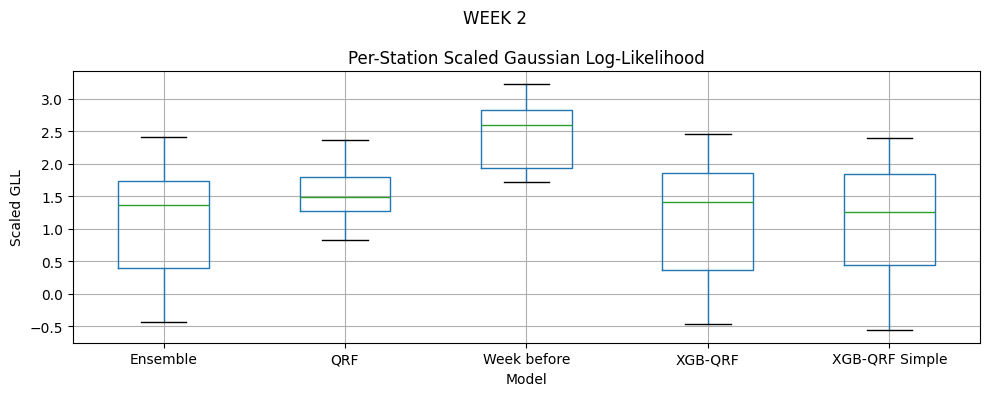

Predicting week 3


/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:196: RuntimeWarning: divide by zero encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:196: RuntimeWarning: invalid value encountered in divide
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:196: RuntimeWarning: divide by zero encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:196: RuntimeWarning: invalid value encountered in divide
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:196: RuntimeWarning: divide by zero encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/sr

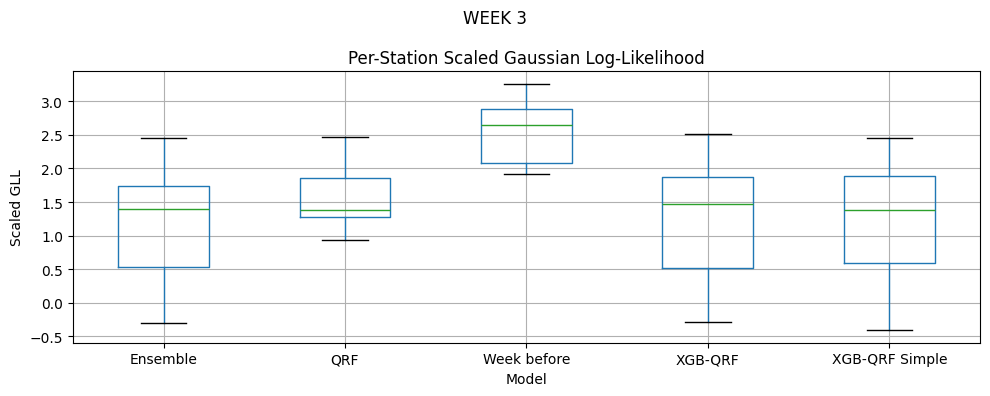

In [135]:
y_train_stations = dataset_train["station_code"].values

X_train_eval = X_train.drop(columns=["station_code"])
for i in range(NUMBER_OF_WEEK):
    predictions = []
    baseline_day_before = dataset_train["water_flow_lag_1w"]
    predictions.append(
        {
            "model": "Week before",
            "prediction": baseline_day_before,
            "dataset": "train",
            "stations": y_train_stations,
            "prediction_interval": None,
        }
    )
    if "qrf" in FINAL_MODELS:
        y_pred_qrf = qrf[i].predict(
            X_train_eval, quantiles="mean", aggregate_leaves_first=False
        )
        y_pis_qrf = qrf[i].predict(X_train_eval, quantiles=[ALPHA / 2, 1 - ALPHA / 2])

        predictions.append(
            {
                "model": "QRF",
                "prediction": y_pred_qrf,
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": y_pis_qrf,
            }
        )
    if "xgb_qrf" in FINAL_MODELS:
        xt_eval = X_train_eval.fillna(0)
        y_pred_xgb_qrf = xgb_qrf_models[i].predict(xt_eval)
        y_interval_xgb_qrf = np.stack(
            [
                y_pred_xgb_qrf[:, 0],
                y_pred_xgb_qrf[:, 2],
            ],
            axis=1,
        )

        predictions.append(
            {
                "model": "XGB-QRF",
                "prediction": y_pred_xgb_qrf[:, 1],
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": y_interval_xgb_qrf,
            }
        )
    if "xgb_qrf_simple" in FINAL_MODELS:
        xt_eval = X_train_eval.fillna(0)
        print(f"Predicting week {i}")
        y_pred_xgb_qrf = xgb_qrf_simple_models[i].predict(xt_eval)
        y_interval_xgb_qrf = np.stack(
            [
                y_pred_xgb_qrf[:, 0],
                y_pred_xgb_qrf[:, 2],
            ],
            axis=1,
        )

        predictions.append(
            {
                "model": "XGB-QRF Simple",
                "prediction": y_pred_xgb_qrf[:, 1],
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": y_interval_xgb_qrf,
            }
        )
    if "ensemble" in FINAL_MODELS:
        ensemble_predictions = ensemble_models[i].predict(X_train_eval.fillna(0))
        ensemble_intervals = np.stack(
            [
                ensemble_predictions[:, 0],
                ensemble_predictions[:, 2],
            ],
            axis=1,
        )
        ensemble_predictions = ensemble_predictions[:, 1]

        predictions.append(
            {
                "model": "Ensemble",
                "prediction": ensemble_predictions,
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": ensemble_intervals,
            }
        )

    compare_models_per_station(
        Y_train[i].values,
        predictions,
        y_train_stations,
        column_to_display="log_likelihood",
        title=f"WEEK {i}",
    )

### 4. Coverage on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


In [136]:
for i in range(NUMBER_OF_WEEK):

    baseline_day_before = dataset_train["water_flow_lag_1w"]
    if "mapie" in FINAL_MODELS:
        y_pred_mapie, y_pis_mapie = mapie[i].predict(X_train_eval)
        coverage = (y_train[i].values >= y_pis_mapie[:, 0, 0]) & (
            y_train[i].values <= y_pis_mapie[:, 1, 0]
        )
        print(
            f"MAPIE coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
    if "qrf" in FINAL_MODELS:
        y_pred_qrf = qrf[i].predict(
            X_train_eval, quantiles="mean", aggregate_leaves_first=False
        )
        y_pis_qrf = qrf[i].predict(X_train_eval, quantiles=[ALPHA / 2, 1 - ALPHA / 2])
        coverage = (y_train[i].values >= y_pis_qrf[:, 0]) & (
            y_train[i].values <= y_pis_qrf[:, 1]
        )
        print(
            f"QRF coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
    if "xgb_qrf" in FINAL_MODELS:
        y_pred_xgb_qrf = xgb_qrf_models[i].predict(X_train_eval)
        y_interval_xgb_qrf = np.stack(
            [
                xgb_qrf_models[i].predict(X_train_eval)[:, 0],
                xgb_qrf_models[i].predict(X_train_eval)[:, 2],
            ],
            axis=1,
        )
        coverage = (y_train[i].values >= y_interval_xgb_qrf[:, 0]) & (
            y_train[i].values <= y_interval_xgb_qrf[:, 1]
        )
        print(
            f"XGB-QRF coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
    if "xgb_qrf_simple" in FINAL_MODELS:
        y_pred_xgb_qrf = xgb_qrf_simple_models[i].predict(X_train_eval)
        y_interval_xgb_qrf = np.stack(
            [
                xgb_qrf_simple_models[i].predict(X_train_eval)[:, 0],
                xgb_qrf_simple_models[i].predict(X_train_eval)[:, 2],
            ],
            axis=1,
        )
        coverage = (y_train[i].values >= y_interval_xgb_qrf[:, 0]) & (
            y_train[i].values <= y_interval_xgb_qrf[:, 1]
        )
        print(
            f"XGB-QRF Simple coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
    if "ebm" in FINAL_MODELS:
        y_pred_ebm = []
        for model in ebm_ensembles[i]:
            y_pred_ebm.append(model.predict(X_train_eval))
        y_pred_ebm = np.mean(y_pred_ebm, axis=0)
        coverage = (y_train[i].values >= y_pis_qrf[:, 0]) & (
            y_train[i].values <= y_pis_qrf[:, 1]
        )
        print(
            f"EBM coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
    if "lgbm" in FINAL_MODELS:
        y_pred_lgbm = lgbm[i][0.5].predict(X_train_eval)
        y_pis_lgbm = np.stack(
            [lgbm[i][0.05].predict(X_train_eval), lgbm[i][0.95].predict(X_train_eval)],
            axis=1,
        )
        coverage = (y_train[i].values >= y_pis_lgbm[:, 0]) & (
            y_train[i].values <= y_pis_lgbm[:, 1]
        )
        print(
            f"lgbm coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
    if "xgb" in FINAL_MODELS:
        X_train_eval_xgb = X_train_eval.drop(columns=["north_hemisphere"])
        y_pred_xgb = xgb_models[i][0.5].predict(X_train_eval_xgb)
        y_pred_lower = xgb_models[i][0.05].predict(X_train_eval_xgb)

        y_pred_lower.fill(0)
        print(y_pred_lower)
        y_interval_xgb = np.stack(
            [
                y_pred_lower,
                xgb_models[i][0.95].predict(X_train_eval_xgb),
            ],
            axis=1,
        )
        coverage = (y_train[i].values >= y_interval_xgb[:, 0]) & (
            y_train[i].values <= y_interval_xgb[:, 1]
        )
        print(
            f"XGB coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
    if "deep_ensemble" in FINAL_MODELS:
        y_pred_deep = []
        for model in deep_ensembles[i]:
            y_pred_deep.append(model.predict(X_train_eval))
        intervals = np.percentile(y_pred_deep, [0, 100], axis=0)
        intervals = intervals[:, :, 0].T
        coverage = (y_train[i].values >= intervals[:, 0]) & (
            y_train[i].values <= intervals[:, 1]
        )
        print(
            f"Deep Ensemble coverage of the prediction interval for week {i}: {coverage.mean()}"
        )

ValueError: operands could not be broadcast together with shapes (14532,) (27702,) 